In [ ]:
## Requirements
- Python 3.10
- Jupyter Notebook
- See `requirements.txt` for Python packages


EEG to BIS: Machine Learning Model Development

Section 1: Importing libraries needed for building the model

In [21]:

# ============================
# 1️⃣ Import libraries
# ============================
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report,roc_curve, auc 

Section 2. Load the data for exploratory analysis
    Load the first file and get the keys and their shape
    Go through all the data files. Each .mat file may contain EEG windows of different lengths. Check the window size for all files and choose the smallest window size.
    Use this to rebuild X and y and combine all the files.
    Check the class distribution to choose multiclass or binary class option for the model

In [23]:
# go through all the data files
data_dir = "../data"
files = [f for f in os.listdir(data_dir) if f.endswith(".mat")]

print("Number of .mat files:", len(files))

Number of .mat files: 24


In [24]:
## have to determine the window size to use since the files may be of different size.
window_sizes = []

for file in files:
    file_path = os.path.join(data_dir, file)
    
    with h5py.File(file_path, 'r') as f:
        EEG = f['EEG'][:].flatten()
        bis = f['bis'][:].flatten()
    
    window_size = len(EEG) // len(bis)
    window_sizes.append(window_size)

print("Window sizes per file:", window_sizes)
print("Minimum window size:", min(window_sizes))

Window sizes per file: [627, 623, 624, 623, 627, 622, 624, 625, 624, 624, 615, 624, 624, 624, 622, 623, 624, 625, 622, 621, 621, 624, 624, 624]
Minimum window size: 615


In [6]:
# ============================
# Load the .mat dataset for exploration
# ============================

file_path = "../data/case1.mat"

with h5py.File(file_path, 'r') as f:
    # List all groups (variables) in the file
    keys = list(f.keys())
    print("Keys:", keys)
    data_X = f[keys[0]][:] 
    y  = f[keys[1]][:].ravel()
    for key in f.keys():
        print(f"Shape of {key}:", f[key].shape)
    


Keys: ['EEG', 'bis']
Shape of EEG: (1, 481384)
Shape of bis: (1, 767)


In [7]:
#choose the minimum window size since the window sizes vary as BIS might have been computed on slightly different windows
FIXED_WINDOW_SIZE = min(window_sizes)

In [8]:
X_all = []
y_all = []

for file in files:
    file_path = os.path.join(data_dir, file)
    
    with h5py.File(file_path, 'r') as f:
        EEG = f['EEG'][:].flatten()
        bis = f['bis'][:].flatten()
    
    usable_length = FIXED_WINDOW_SIZE * len(bis)
    EEG = EEG[:usable_length]
    
    X = EEG.reshape(len(bis), FIXED_WINDOW_SIZE)
    y = bis
    
    X_all.append(X)
    y_all.append(y)

The EEG signal was provided as a continuous time series and BIS values were provided per segment.Since the total EEG length was not perfectly divisible by the number of BIS values, the EEG signal was trimmed and segmented into fixed-length windows corresponding to each BIS measurement

In [9]:
X_final = np.vstack(X_all)
y_final = np.concatenate(y_all)

print("Final X shape:", X_final.shape)
print("Final y shape:", y_final.shape)

Final X shape: (34300, 615)
Final y shape: (34300,)


In [10]:
##check the class distribution
def bis_to_class(bis):
    if bis<40: 
        return 0
    elif bis <60:
        return 1
    else:
        return 2
y_multi_class = np.array([bis_to_class(b) for b in y_final])
unique, counts = np.unique(y_multi_class, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(15872), np.int64(1): np.int64(12317), np.int64(2): np.int64(6111)}


Since the class distibution in imbalanced, binary class was chosen for BIS

In [11]:
# Convert BIS to binary classes
y_class = (y_final < 60).astype(int)

# Check balance
print("Class distribution:", np.bincount(y_class))

Class distribution: [ 6111 28189]


Split the data into a training and a test set (80:20)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

Build the first classification model
Base model: Logistic Regression

In [13]:
## base model - Logistic Regression
pipeline_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)
y_proba = pipeline_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Logistic Regression Results
Accuracy: 0.8173469387755102
ROC-AUC: 0.48805814995160846
              precision    recall  f1-score   support

           0       0.17      0.01      0.01      1222
           1       0.82      0.99      0.90      5638

    accuracy                           0.82      6860
   macro avg       0.50      0.50      0.46      6860
weighted avg       0.71      0.82      0.74      6860



Although Logistic regression model achieved high accuracy (81.73%), the ROC-AUC score is 0.48, which is worse than random classification. The recall of 0.01 for the minority class indicates poor discriminative ability. this poor performance is driven by class imbalance. 

Model 2: Logistic Regression with balanced class weight

In [14]:
# LR - fix the class weight imbalance
#fix the class weight imbalance
pipeline_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [15]:
# Logistic regression with correction
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)
y_proba = pipeline_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Logistic Regression Results
Accuracy: 0.5384839650145773
ROC-AUC: 0.48786953331061317
              precision    recall  f1-score   support

           0       0.17      0.42      0.25      1222
           1       0.82      0.56      0.67      5638

    accuracy                           0.54      6860
   macro avg       0.50      0.49      0.46      6860
weighted avg       0.70      0.54      0.59      6860



Even with balanced class weight, minority class recall improved but still the ROC-AUC was <0.5

Model 3: Random Forest

In [17]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Results
Accuracy: 0.8244897959183674
ROC-AUC: 0.7817573381235235
              precision    recall  f1-score   support

           0       0.67      0.03      0.05      1222
           1       0.83      1.00      0.90      5638

    accuracy                           0.82      6860
   macro avg       0.75      0.51      0.48      6860
weighted avg       0.80      0.82      0.75      6860



Model 4: Random Forest with class weighting

In [18]:
# Adding class weight to Random Forest
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [19]:
pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Results
Accuracy: 0.8284256559766764
ROC-AUC: 0.7579502023038662
              precision    recall  f1-score   support

           0       0.61      0.10      0.17      1222
           1       0.83      0.99      0.90      5638

    accuracy                           0.83      6860
   macro avg       0.72      0.54      0.54      6860
weighted avg       0.80      0.83      0.77      6860



Without class balancing, the Random Forest model exhibited a strong bias toward the deep anesthesia class (recall = 1.00) and performed poorly on the non-deep anesthesia class (recall = 0.03). After applying class balancing, the recall for the minority class improved to 0.10, and the macro F1-score increased from 0.48 to 0.54, indicating improved overall class balance. However, the model still demonstrated limited ability to distinguish between the two classes. This limitation may be attributed to overlapping feature distributions across classes and to the need for further feature engineering and decision-threshold optimization. These aspects can be explored in future work.

Random Forest Results
Accuracy: 0.8284256559766764
ROC-AUC: 0.7579502023038662

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.10      0.17      1222
           1       0.83      0.99      0.90      5638

    accuracy                           0.83      6860
   macro avg       0.72      0.54      0.54      6860
weighted avg       0.80      0.83      0.77      6860



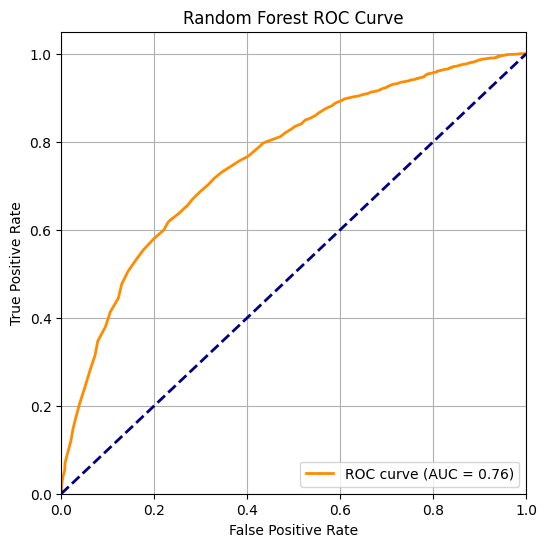

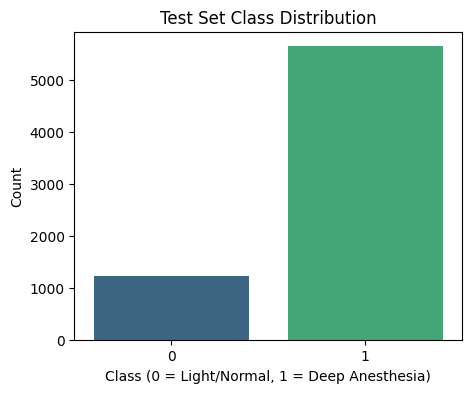

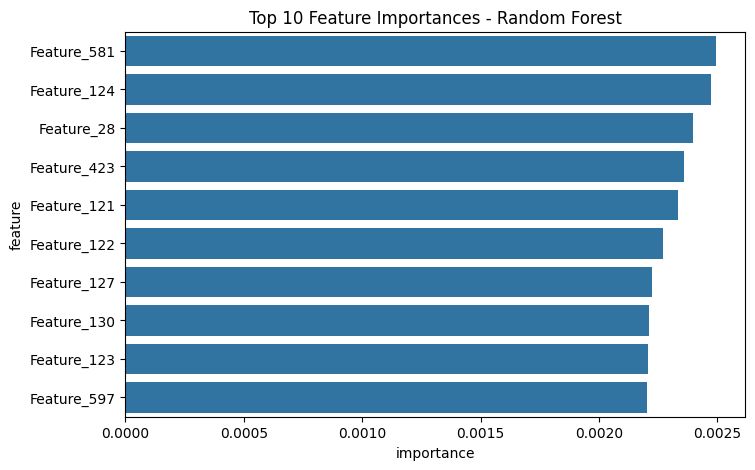

In [20]:
# figures
# 1 Predictions
# ============================
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ============================
# 2 ROC Curve
# ============================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ============================
# 3 Class Distribution
# ============================
df_plot = pd.DataFrame({'BIS_class': y_test})

plt.figure(figsize=(5,4))
sns.countplot(x='BIS_class',hue = 'BIS_class', data=df_plot, palette='viridis',legend = False)
plt.title('Test Set Class Distribution')
plt.xlabel('Class (0 = Light/Normal, 1 = Deep Anesthesia)')
plt.ylabel('Count')
plt.show()

# ============================
# 4 Feature Importance (Top 10)
# ============================
feature_names = [f"Feature_{i}" for i in range(X_test.shape[1])]

importances = pipeline_rf.named_steps['model'].feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()
